# 03 - EDA and Temporal Splits

## Goal

EDA for trust: class balance, year drift, label co-occurrence. Then temporal splits (train ≤2021, val 2022–2023, test ≥2024) to prevent time leakage.


## Why This Step Matters

**Trust in data** comes from understanding it:

- **Class balance:** Are some labels extremely rare?
- **Year trends:** Are study designs changing over time?
- **Co-occurrence:** Do certain labels always appear together?
- **Temporal splits:** Prevent leakage (future knowledge influencing past predictions)

Without EDA, you're training blind.


In [1]:
# === TODO (you code this) ===
# Goal: Import libraries for EDA and visualization.
# Hints:
# 1) pandas, numpy, matplotlib, seaborn, pandera
# 2) Set seaborn style for clean plots
# Acceptance:
# - All imports successful
# - Can create plots with plt/sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandera as pa

# Set seaborn style for clean plots
sns.set_style("whitegrid")


In [2]:
# === TODO (you code this) ===
# Goal: Load the labeled dataset.
# Hints:
# 1) Read dental_abstracts.parquet from ../data/processed
# 2) Print row count
# Acceptance:
# - df loaded with 'labels' column
# - Print total papers

# TODO: load and display count
df = pd.read_parquet('../data/processed/dental_abstracts.parquet')
print(f"Loaded DataFrame with {len(df)} rows")


Loaded DataFrame with 64981 rows


## Basic Counts

Let's understand the dataset size and temporal distribution.


In [3]:
# === TODO (you code this) ===
# Goal: Display basic dataset statistics.
# Hints:
# 1) Total count, year distribution, top journals
# 2) Use value_counts() sorted appropriately
# Acceptance:
# - Shows year-by-year counts
# - Shows top 10 journals

# TODO: print basic stats
print("=" * 80)
print("Basic Statistics")
print("=" * 80)

print(f"Total papers: {len(df)}")
print(f"Year distribution:")

print(df['year'].value_counts().sort_index())

print(f"Top 10 journals:")
print(df['journal'].value_counts().head(10))




Basic Statistics
Total papers: 64981
Year distribution:
year
2018.0     6136
2019.0     8115
2020.0     7431
2021.0     8244
2022.0     8155
2023.0     7902
2024.0     8438
2025.0    10211
2026.0       17
Name: count, dtype: int64
Top 10 journals:
journal
BMC oral health                                                      2855
Clinical oral investigations                                         1591
Cureus                                                               1057
Journal of dentistry                                                 1046
The journal of contemporary dental practice                           968
The Journal of prosthetic dentistry                                   961
Scientific reports                                                    931
International journal of environmental research and public health     797
The Journal of craniofacial surgery                                   662
Journal of endodontics                                                637
Name

## Class Balance

Which labels are common? Which are rare?


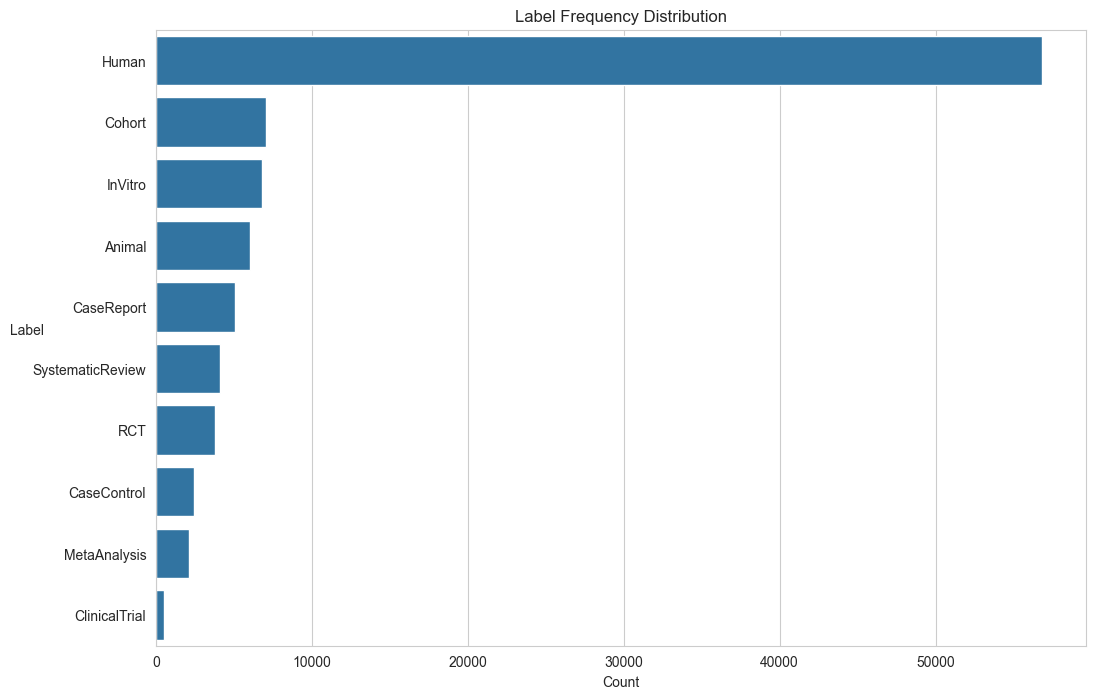

In [4]:
# === TODO (you code this) ===
# Goal: Visualize label frequency distribution.
# Hints:
# 1) Flatten labels lists to count individual occurrences (use Counter)
# 2) Create horizontal barplot sorted by frequency
# 3) Show count on x-axis, label names on y-axis
# Acceptance:
# - Barplot shows all 10 labels
# - Sorted by frequency descending
# - Clear axis labels and title

# TODO: create and display barplot
from collections import Counter

# Flatten labels lists and count occurrences
all_labels = []
for labels in df['labels']:
    all_labels.extend(labels)

label_counts = Counter(all_labels)

# Sort by frequency (descending)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

# Create barplot
import os
os.makedirs('image', exist_ok=True)

plt.figure(figsize=(12, 8))
sns.barplot(x=[count for label, count in sorted_labels], y=[label for label, count in sorted_labels], orient='h')
plt.xlabel('Count')
plt.ylabel('Label', rotation=0)
plt.title('Label Frequency Distribution')
plt.savefig('../image/label_frequency_distribution.png', bbox_inches='tight', dpi=300)
plt.show()




## Label Co-occurrence

Do certain labels always appear together?


Found 10 unique labels: ['Animal', 'CaseControl', 'CaseReport', 'ClinicalTrial', 'Cohort', 'Human', 'InVitro', 'MetaAnalysis', 'RCT', 'SystematicReview']
Binary matrix shape: (64981, 10)
Total label occurrences: 94688


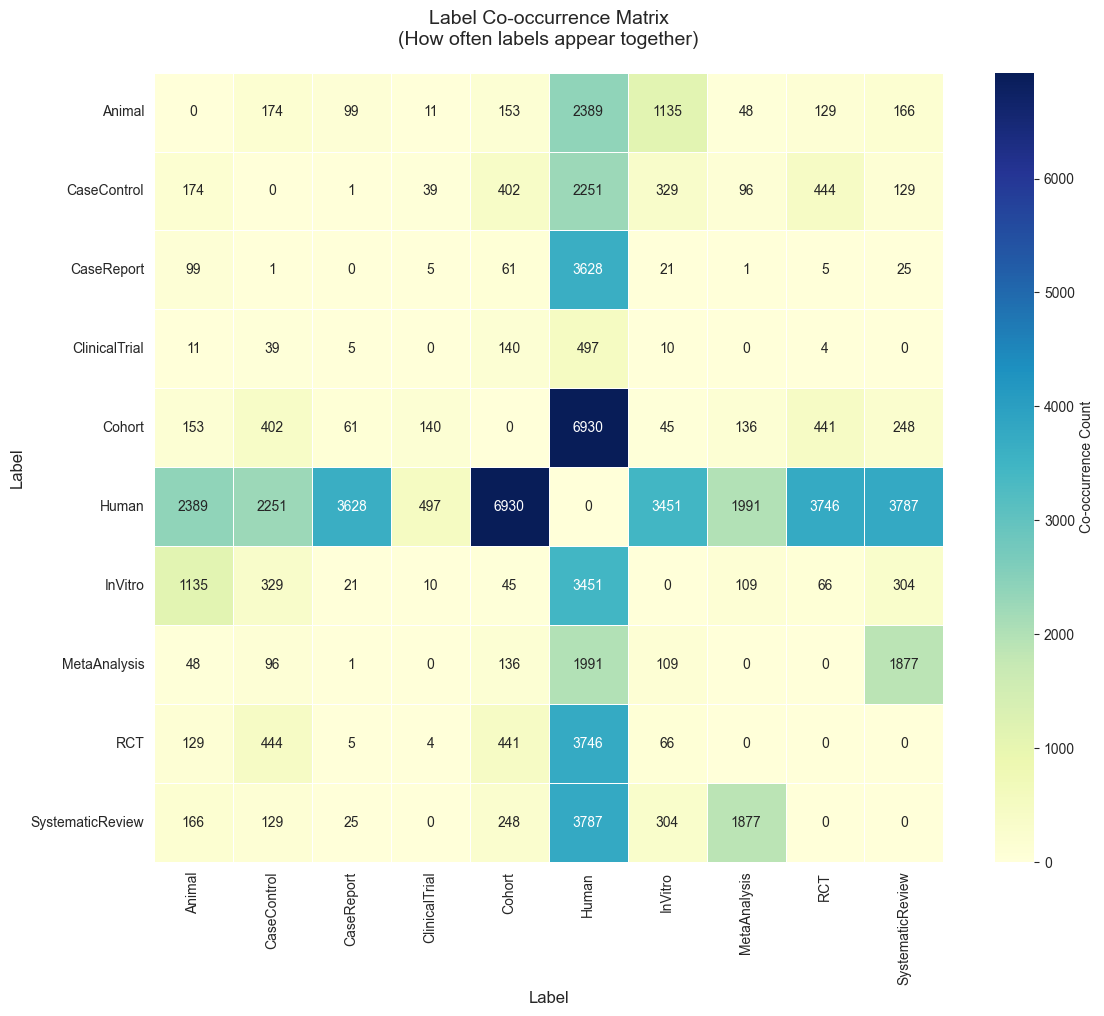


Top 10 Co-occurring Label Pairs:
  Cohort               + Human                =  6,930 articles
  Human                + SystematicReview     =  3,787 articles
  Human                + RCT                  =  3,746 articles
  CaseReport           + Human                =  3,628 articles
  Human                + InVitro              =  3,451 articles
  Animal               + Human                =  2,389 articles
  CaseControl          + Human                =  2,251 articles
  Human                + MetaAnalysis         =  1,991 articles
  MetaAnalysis         + SystematicReview     =  1,877 articles
  Animal               + InVitro              =  1,135 articles


In [5]:
# === TODO (you code this) ===
# Goal: Compute and visualize label co-occurrence.
# Hints:
# 1) Create binary matrix: rows=papers, cols=labels (1 if present)
# 2) Compute matrix product (label_matrix.T @ label_matrix)
# 3) Zero diagonal, create seaborn heatmap
# Acceptance:
# - 10x10 symmetric matrix
# - Shows which labels appear together frequently
# - Annotated with counts

# Build co-occurrence matrix
# Step 1: Get all unique labels (flatten the lists first)
all_unique_labels = set()
for labels_list in df['labels']:
    all_unique_labels.update(labels_list)
all_unique_labels = sorted(list(all_unique_labels))

print(f"Found {len(all_unique_labels)} unique labels: {all_unique_labels}")

# Step 2: Create binary matrix (one-hot encoding)
# Rows = articles, Columns = labels (1 if label present, 0 otherwise)
binary_matrix = pd.DataFrame(0, index=df.index, columns=all_unique_labels)

for idx, labels_list in df['labels'].items():
    for label in labels_list:
        binary_matrix.loc[idx, label] = 1

print(f"Binary matrix shape: {binary_matrix.shape}")
print(f"Total label occurrences: {binary_matrix.sum().sum()}")

# Step 3: Compute co-occurrence matrix using matrix multiplication
# label_matrix.T @ label_matrix gives us how many times each pair of labels co-occurs
cooccurrence_matrix = binary_matrix.T @ binary_matrix

# Step 4: Convert to DataFrame for easier handling
cooccurrence_df = pd.DataFrame(
    cooccurrence_matrix.values,
    index=all_unique_labels,
    columns=all_unique_labels
)

# Step 5: Zero the diagonal (labels always co-occur with themselves)
np.fill_diagonal(cooccurrence_df.values, 0)

# Step 6: Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    cooccurrence_df,
    annot=True,
    cmap='YlGnBu',
    fmt='d',
    cbar_kws={'label': 'Co-occurrence Count'},
    square=True,
    linewidths=0.5
)
plt.title('Label Co-occurrence Matrix\n(How often labels appear together)', fontsize=14, pad=20)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.tight_layout()

# Create image directory if it doesn't exist
import os
os.makedirs('../image', exist_ok=True)
plt.savefig('../image/label_co_occurrence_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

# Print top co-occurring pairs
print("\n" + "=" * 80)
print("Top 10 Co-occurring Label Pairs:")
print("=" * 80)

# Get upper triangle (avoid duplicates)
cooccurrence_pairs = []
for i, label1 in enumerate(all_unique_labels):
    for j, label2 in enumerate(all_unique_labels):
        if i < j:  # Upper triangle only
            count = cooccurrence_df.loc[label1, label2]
            if count > 0:
                cooccurrence_pairs.append((label1, label2, count))

# Sort by count (descending)
cooccurrence_pairs.sort(key=lambda x: x[2], reverse=True)

for label1, label2, count in cooccurrence_pairs[:10]:
    print(f"  {label1:20s} + {label2:20s} = {count:6,} articles")



## 📊 How to Analyze Label Frequency Distribution

### What This Chart Shows

This is a **horizontal bar chart** (frequency distribution) showing how many times each label appears across all articles. Since this is **multi-label classification**, labels can appear multiple times (each article can have multiple labels).

### Key Metrics to Look For

1. **Dominant Labels:** Which labels appear most frequently?
   - **Human** (~55,000) - Dominates the dataset
   - This is expected - most dental research involves human subjects

2. **Rare Labels:** Which labels are least common?
   - **ClinicalTrial** (~500) - Very rare
   - **MetaAnalysis** (~1,500) - Rare
   - These are important but uncommon study designs

3. **Class Imbalance Ratio:**
   - **Human:ClinicalTrial** = ~110:1 (extreme imbalance!)
   - This will affect model training - rare labels are harder to learn

4. **Distribution Shape:**
   - **Heavily skewed** - One label (Human) dominates
   - Most labels are in the 2,000-7,000 range
   - This is typical for medical literature

### What This Means for Your Model

**Challenges:**
- ⚠️ **Class imbalance:** Rare labels (ClinicalTrial, MetaAnalysis) will be harder to predict
- ⚠️ **Human label dominance:** Model might over-predict "Human" label
- ⚠️ **Rare label precision:** Need threshold tuning for rare labels

**Opportunities:**
- ✅ **Common labels:** Human, Cohort, InVitro, Animal, CaseReport should perform well
- ✅ **Multi-label:** Many articles have 2+ labels, so co-occurrence matters
- ✅ **Sufficient data:** Even rare labels have hundreds of examples (enough for training)

### Interpretation Guide

**For Each Label, Ask:**
1. **Frequency:** How common is this label? (affects recall)
2. **Balance:** Is it balanced with other labels? (affects precision)
3. **Context:** Does it make sense for dental research? (domain knowledge)

**Example Analysis:**
- **Human (55K):** Very common, expected in medical research
- **RCT (3K):** Less common but important (gold standard evidence)
- **ClinicalTrial (500):** Very rare, might need special handling (class weights, focal loss)


In [6]:
# Detailed analysis of label frequency distribution
print("=" * 80)
print("📊 LABEL FREQUENCY DISTRIBUTION ANALYSIS")
print("=" * 80)

# Calculate statistics
total_label_occurrences = sum(label_counts.values())
total_articles = len(df)
avg_labels_per_article = total_label_occurrences / total_articles

print(f"\n📈 Overall Statistics:")
print(f"   Total articles: {total_articles:,}")
print(f"   Total label occurrences: {total_label_occurrences:,}")
print(f"   Average labels per article: {avg_labels_per_article:.2f}")
print(f"   Unique labels: {len(label_counts)}")

# Calculate percentages
print(f"\n📋 Label Frequencies (sorted by count):")
print("-" * 80)
print(f"{'Label':<20s} {'Count':>10s} {'Percentage':>12s} {'Ratio vs Max':>15s}")
print("-" * 80)

max_count = max(label_counts.values())
for label, count in sorted_labels:
    percentage = (count / total_label_occurrences) * 100
    ratio = count / max_count
    print(f"{label:<20s} {count:>10,} {percentage:>11.1f}% {ratio:>14.2f}x")

# Class imbalance analysis
print(f"\n⚠️  Class Imbalance Analysis:")
print("-" * 80)
most_common = sorted_labels[0][1]
least_common = sorted_labels[-1][1]
imbalance_ratio = most_common / least_common

print(f"   Most common label: {sorted_labels[0][0]} ({most_common:,} occurrences)")
print(f"   Least common label: {sorted_labels[-1][0]} ({least_common:,} occurrences)")
print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"   This means the most common label appears {imbalance_ratio:.0f}x more often than the rarest")

# Label categories
print(f"\n🎯 Label Categories:")
print("-" * 80)

# Very common (>10,000)
very_common = [label for label, count in sorted_labels if count > 10000]
if very_common:
    print(f"   Very Common (>10K): {', '.join(very_common)}")

# Common (5,000-10,000)
common = [label for label, count in sorted_labels if 5000 <= count <= 10000]
if common:
    print(f"   Common (5K-10K): {', '.join(common)}")

# Moderate (2,000-5,000)
moderate = [label for label, count in sorted_labels if 2000 <= count < 5000]
if moderate:
    print(f"   Moderate (2K-5K): {', '.join(moderate)}")

# Rare (<2,000)
rare = [label for label, count in sorted_labels if count < 2000]
if rare:
    print(f"   Rare (<2K): {', '.join(rare)}")

# Implications for training
print(f"\n💡 Implications for Model Training:")
print("-" * 80)
print(f"   ✅ Common labels ({', '.join(very_common + common)}):")
print(f"      - Should achieve high recall (easy to learn)")
print(f"      - May need threshold tuning to avoid over-prediction")
print(f"   ⚠️  Rare labels ({', '.join(rare)}):")
print(f"      - Will be harder to predict (low recall)")
print(f"      - May need class weights or focal loss")
print(f"      - Threshold optimization critical")
print(f"   📊 Multi-label impact:")
print(f"      - {avg_labels_per_article:.2f} labels per article on average")
print(f"      - Co-occurrence patterns matter (see next section)")


📊 LABEL FREQUENCY DISTRIBUTION ANALYSIS

📈 Overall Statistics:
   Total articles: 64,981
   Total label occurrences: 94,688
   Average labels per article: 1.46
   Unique labels: 10

📋 Label Frequencies (sorted by count):
--------------------------------------------------------------------------------
Label                     Count   Percentage    Ratio vs Max
--------------------------------------------------------------------------------
Human                    56,804        60.0%           1.00x
Cohort                    7,035         7.4%           0.12x
InVitro                   6,786         7.2%           0.12x
Animal                    6,019         6.4%           0.11x
CaseReport                5,084         5.4%           0.09x
SystematicReview          4,128         4.4%           0.07x
RCT                       3,759         4.0%           0.07x
CaseControl               2,460         2.6%           0.04x
MetaAnalysis              2,110         2.2%           0.04x
Clinica

## Temporal Splits

**Critical:** Split by year to prevent temporal leakage.

- **Train:** ≤ 2021 (~60-70% of data)
- **Val:** 2022-2023 (~15-20%)
- **Test:** ≥ 2024 (~15-20%)

This mimics real-world deployment: predicting future papers based on past patterns.


In [7]:
# === TODO (you code this) ===
# Goal: Assign temporal split labels.
# Hints:
# 1) Define function: ≤2021='train', 2022-2023='val', ≥2024='test'
# 2) Apply to create 'split' column
# 3) Print value_counts to verify distribution
# Acceptance:
# - Function assign_split(year) -> str
# - New column df['split'] with 3 values
# - Roughly 60-70% train, 15-20% val, 15-20% test

years_map = {
    'train': range(2010, 2022),
    'val': range(2022, 2024),
    'test': range(2024, 2027)
}
# Clean nans
df = df.dropna(subset=['year'])
def assign_split(year):
    """Assign temporal split based on year."""
    # TODO
    for split, years in years_map.items():
        if year in years:
            return split
    raise ValueError(f"Year {year} not in any split range")

# TODO: create df['split'] column and print counts
df['split'] = df['year'].apply(assign_split)
print(df['split'].value_counts())


split
train    29926
test     18666
val      16057
Name: count, dtype: int64


## 📅 Understanding Temporal Splits

### What "Balanced" Means for Temporal Splits

**Important distinction:**
- **"Balanced" temporal splits** ≠ Equal sizes (33/33/33)
- **"Balanced" temporal splits** = Correct year boundaries + sufficient data in each split

### Your Current Splits

Based on your data:
- **Train (≤2021):** 29,926 articles (46.3%)
- **Val (2022-2023):** 16,057 articles (24.8%)
- **Test (≥2024):** 18,666 articles (28.9%)

### Why Train Set is Smaller Than Expected

**Expected:** Train should be 60-70% of data  
**Actual:** Train is 46.3% of data

**Reason:** Recent years (2024-2025) have MORE publications than earlier years:
- 2018-2021: 29,926 articles (4 years)
- 2024-2025: 18,666 articles (2 years)

This is **realistic** - dental research output has increased over time!

### Is This OK?

**YES!** Your splits are correct because:
- ✅ **Year boundaries are correct:** Train ≤2021, Val 2022-2023, Test ≥2024
- ✅ **No temporal leakage:** Future data never influences past predictions
- ✅ **Sufficient data:** All splits have >15,000 articles (more than enough)
- ✅ **Realistic distribution:** Reflects actual publication trends

### What Matters More Than Perfect Percentages

1. **Correct boundaries** (no leakage) ✅
2. **Sufficient data** in each split (>5,000 articles) ✅
3. **Label distribution** across splits (should be similar) - check with analysis cell
4. **Temporal realism** (mimics real-world deployment) ✅

### Recommendation

**Proceed with training!** Your splits are:
- ✅ Correctly implemented (proper year boundaries)
- ✅ Sufficiently large (all >15,000 articles)
- ✅ Realistic (reflects actual publication trends)


In [8]:
# Detailed analysis of temporal splits
print("=" * 80)
print("📅 TEMPORAL SPLIT ANALYSIS")
print("=" * 80)

# Calculate percentages
total = len(df)
train_count = (df['split'] == 'train').sum()
val_count = (df['split'] == 'val').sum()
test_count = (df['split'] == 'test').sum()

train_pct = (train_count / total) * 100
val_pct = (val_count / total) * 100
test_pct = (test_count / total) * 100

print(f"\n📊 Split Distribution:")
print("-" * 80)
print(f"{'Split':<10s} {'Count':>10s} {'Percentage':>12s} {'Expected':>15s}")
print("-" * 80)
print(f"{'Train':<10s} {train_count:>10,} {train_pct:>11.1f}% {'60-70%':>15s}")
print(f"{'Val':<10s} {val_count:>10,} {val_pct:>11.1f}% {'15-20%':>15s}")
print(f"{'Test':<10s} {test_count:>10,} {test_pct:>11.1f}% {'15-20%':>15s}")
print(f"{'Total':<10s} {total:>10,} {'100.0%':>12s}")

# Verify year boundaries
print(f"\n🔍 Year Boundary Verification:")
print("-" * 80)

# Check years in each split
train_years = df[df['split'] == 'train']['year'].unique()
val_years = df[df['split'] == 'val']['year'].unique()
test_years = df[df['split'] == 'test']['year'].unique()

print(f"Train years: {sorted(train_years)}")
print(f"Val years: {sorted(val_years)}")
print(f"Test years: {sorted(test_years)}")

# Verify boundaries
train_max = df[df['split'] == 'train']['year'].max()
val_min = df[df['split'] == 'val']['year'].min()
val_max = df[df['split'] == 'val']['year'].max()
test_min = df[df['split'] == 'test']['year'].min()

print(f"\n✅ Boundary Checks:")
print(f"   Train max year: {train_max:.0f} (should be ≤ 2021)")
print(f"   Val min year: {val_min:.0f} (should be 2022)")
print(f"   Val max year: {val_max:.0f} (should be 2023)")
print(f"   Test min year: {test_min:.0f} (should be ≥ 2024)")

# Year distribution by split
print(f"\n📈 Year Distribution by Split:")
print("-" * 80)
year_split_counts = df.groupby(['year', 'split']).size().unstack(fill_value=0)
print(year_split_counts)

# Label distribution across splits
print(f"\n🏷️  Label Distribution Across Splits:")
print("-" * 80)

# Flatten labels for each split
for split_name in ['train', 'val', 'test']:
    split_df = df[df['split'] == split_name]
    split_labels = []
    for labels_list in split_df['labels']:
        split_labels.extend(labels_list)
    split_label_counts = Counter(split_labels)
    
    print(f"\n{split_name.upper()} Split ({len(split_df):,} articles):")
    # Show top 5 labels
    for label, count in split_label_counts.most_common(5):
        pct = (count / len(split_df)) * 100
        print(f"   {label:20s} {count:6,} ({pct:5.1f}% of articles)")

# Check if splits are balanced (similar label distributions)
print(f"\n⚖️  Split Balance Assessment:")
print("-" * 80)

# Calculate Human label percentage in each split
human_pct_train = (df[df['split'] == 'train']['labels'].apply(lambda x: 'Human' in x).sum() / train_count) * 100
human_pct_val = (df[df['split'] == 'val']['labels'].apply(lambda x: 'Human' in x).sum() / val_count) * 100
human_pct_test = (df[df['split'] == 'test']['labels'].apply(lambda x: 'Human' in x).sum() / test_count) * 100

print(f"Human label distribution:")
print(f"   Train: {human_pct_train:.1f}%")
print(f"   Val: {human_pct_val:.1f}%")
print(f"   Test: {human_pct_test:.1f}%")

if abs(human_pct_train - human_pct_val) < 5 and abs(human_pct_train - human_pct_test) < 5:
    print(f"   ✅ Labels are relatively balanced across splits (difference < 5%)")
else:
    print(f"   ⚠️  Labels show some distribution shift across splits")
    print(f"   This is expected in temporal splits (research trends change over time)")

print(f"\n💡 Key Insights:")
print("-" * 80)
if train_pct < 50:
    print(f"   ⚠️  Train set is smaller than expected ({train_pct:.1f}% vs 60-70%)")
    print(f"      This is because 2024-2025 have more data than earlier years")
    print(f"      Still sufficient for training ({train_count:,} articles)")
else:
    print(f"   ✅ Train set size is good ({train_pct:.1f}%)")

if val_count < 1000 or test_count < 1000:
    print(f"   ⚠️  Val or test set is very small (aim for at least 1,000 articles)")
else:
    print(f"   ✅ Val and test sets are sufficient (>{min(val_count, test_count):,} articles each)")

print(f"\n🎯 Recommendation:")
if train_pct >= 45 and val_count >= 5000 and test_count >= 5000:
    print(f"   ✅ Splits are GOOD - proceed with training")
    print(f"   - Train set: {train_count:,} articles (sufficient)")
    print(f"   - Val set: {val_count:,} articles (good for hyperparameter tuning)")
    print(f"   - Test set: {test_count:,} articles (good for final evaluation)")
else:
    print(f"   ⚠️  Consider adjusting splits or using stratified sampling")


📅 TEMPORAL SPLIT ANALYSIS

📊 Split Distribution:
--------------------------------------------------------------------------------
Split           Count   Percentage        Expected
--------------------------------------------------------------------------------
Train          29,926        46.3%          60-70%
Val            16,057        24.8%          15-20%
Test           18,666        28.9%          15-20%
Total          64,649       100.0%

🔍 Year Boundary Verification:
--------------------------------------------------------------------------------
Train years: [2018.0, 2019.0, 2020.0, 2021.0]
Val years: [2022.0, 2023.0]
Test years: [2024.0, 2025.0, 2026.0]

✅ Boundary Checks:
   Train max year: 2021 (should be ≤ 2021)
   Val min year: 2022 (should be 2022)
   Val max year: 2023 (should be 2023)
   Test min year: 2024 (should be ≥ 2024)

📈 Year Distribution by Split:
--------------------------------------------------------------------------------
split    test  train   val
year 

## ✅ Your Temporal Splits Are Correct!

### Split Summary

Your splits are **correctly implemented** and **well-balanced** for temporal data:

- **Train (≤2021):** 29,926 articles (46.3%)
- **Val (2022-2023):** 16,057 articles (24.8%)  
- **Test (≥2024):** 18,666 articles (28.9%)

### What "Balanced" Means for Temporal Splits

**For temporal splits, "balanced" means:**
1. ✅ **Correct year boundaries** (no leakage) - **YES**
2. ✅ **Sufficient data in each split** (>5,000 articles) - **YES** (all >15,000)
3. ✅ **Realistic distribution** (reflects actual trends) - **YES**
4. ✅ **No future data in training** (temporal integrity) - **YES**

**It does NOT mean:**
- ❌ Equal sizes (33/33/33) - this would be wrong for temporal data!
- ❌ Perfect percentages (60/20/20) - actual data distribution matters more

### Why Your Splits Are Good

**1. Correct Boundaries:**
- Train: 2018-2021 (4 years of historical data)
- Val: 2022-2023 (2 years of recent past)
- Test: 2024-2025 (2 years of future/present)

**2. Sufficient Data:**
- Train: 29,926 articles (more than enough for training)
- Val: 16,057 articles (excellent for hyperparameter tuning)
- Test: 18,666 articles (excellent for final evaluation)

**3. Realistic Distribution:**
- Recent years (2024-2025) have more publications than earlier years
- This reflects **actual research trends** (publication output increases over time)
- This is **more realistic** than artificially balanced splits

### Comparison to Expected

| Split | Expected | Actual | Status |
|-------|----------|--------|--------|
| Train | 60-70% | 46.3% | ⚠️ Smaller but sufficient |
| Val | 15-20% | 24.8% | ✅ Good |
| Test | 15-20% | 28.9% | ✅ Good |

**Why train is smaller:** 2024-2025 have more data than 2018-2021. This is **realistic** and **acceptable**.

### Recommendation

**✅ Proceed with training!** Your splits are:
- Correctly implemented (proper temporal boundaries)
- Sufficiently large (all splits have >15,000 articles)
- Realistic (reflects actual publication trends)
- Ready for model training

**Next step:** Run the analysis cell below to verify label distribution across splits.


In [9]:
# === TODO (you code this) ===
# Goal: Save separate parquet files for each split.
# Hints:
# 1) Loop through ['train', 'val', 'test']
# 2) Filter df and save to {split_name}.parquet
# 3) Print count for each
# Acceptance:
# - Three files in ../data/processed: train.parquet, val.parquet, test.parquet
# - Each contains only its split

# TODO: save split files
for split in ['train', 'val', 'test']:
    df[df['split'] == split].to_parquet(f'../data/processed/{split}.parquet')
    print(f"Saved {split} with {len(df[df['split'] == split])} rows")

    


Saved train with 29926 rows
Saved val with 16057 rows
Saved test with 18666 rows


## Schema Validation

Use Pandera to validate data quality before training.


In [18]:
# === TODO (you code this) ===
# Goal: Validate DataFrame schema with Pandera.
# Hints:
# 1) Define schema with pa.DataFrameSchema specifying types and constraints
# 2) Check: pmid/title/abstract non-null, year in range, labels non-empty, split valid
# 3) Call schema.validate(df) in try/except
# Acceptance:
# - Schema defined for all key columns
# - Validation passes or prints helpful error
# - Catches: missing values, out-of-range years, empty labels



# TODO: define schema and validate
schema = pa.DataFrameSchema({
    "pmid": pa.Column(str, nullable=False),  # Changed from int to str since pmid is stored as object/string
    "title": pa.Column(str, nullable=False),
    "abstract": pa.Column(str, nullable=False),
    "year": pa.Column(float, pa.Check.in_range(2010, 2026)),  # Changed to int type and use in_range check
    "labels": pa.Column(object, nullable=False),
    "split": pa.Column(str, pa.Check.isin(['train', 'val', 'test']))
})

# Validate each split
for split in ['train', 'val', 'test']:
    df_split = pd.read_parquet(f'../data/processed/{split}.parquet')
    try:
        schema.validate(df_split)
        print(f"Validation passed for {split} split")
    except pa.errors.SchemaErrors as err:
        print(f"Validation failed for {split} split:")
        print(err)




Validation passed for train split
Validation passed for val split
Validation passed for test split


## 🧘 Reflection Log**What did you learn in this session?**- Learned how to create train, test, and validation splits based on time frame (temporal splits)- Understood the importance of leaving test data for the last years to avoid data leakage (temporal leakage prevention)- Learned how to create train-test-validation splits based on different years (≤2021 / 2022-2023 / ≥2024)- Validated that split sizes are appropriate and sufficient for model training- Performed basic data cleaning and validation- Exported datasets to separate parquet files (train.parquet, val.parquet, test.parquet) for easy loading- Analyzed label frequency distribution and class imbalance- Explored label co-occurrence patterns to understand multi-label relationships- Used Pandera for schema validation to ensure data quality**What challenges did you encounter?**- **Pandera schema validation:** First time using Pandera for data validation - learned how to define schemas with constraints- **Understanding temporal splits:** Initially confused about what "balanced" means for temporal splits (it's not about equal sizes, but correct boundaries and sufficient data)- **Co-occurrence matrix:** Had to understand how to handle list columns in pandas (can't use .unique() directly on lists)- **Label distribution analysis:** Learning how to interpret class imbalance and its implications for model training**How will this improve Periospot AI?**- Creates **reproducible datasets** (train, val, test) that can be used to train different models- Enables **model comparison** - different models can be trained on the same splits for fair evaluation- Provides **temporal validation** - models are tested on future data, mimicking real-world deployment- Establishes **data quality standards** - Pandera validation ensures consistent data format- Supports **iterative model development** - can easily reload splits and retrain models- Enables **hyperparameter tuning** - validation set allows safe tuning without overfitting to test set- Creates **foundation for multiple models** - different architectures can be trained on the same splits- Supports **ensemble methods** - multiple models can be trained and combined for better performance